# **Estudo de caso**

**Reconhecimento de comandos de voz**


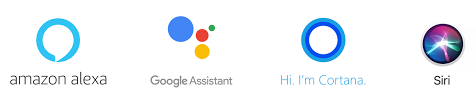

**Base de dados: Mini Speech Commands**

O conjunto de dados original consiste em mais de 105.000 arquivos de áudio no formato de arquivo de áudio WAV (Waveform) de pessoas dizendo 35 palavras diferentes. Mais detalhes sobre a base de dados podem ser vistos nestes link: [speech_commands](https://www.tensorflow.org/datasets/catalog/speech_commands)

Para economizar tempo com o carregamento de dados, será usada uma versão menor do conjunto de dados de Comandos de Fala chamada **mini_speech_commands** que contém clipes de áudio curtos (um segundo ou menos) de 8 comandos: "down", "go", "left", "no", "right", "stop", "up" e "yes".

* A taxa de amostragem para este conjunto de dados é de 16kHz.









## Importando as bibliotecas

In [ ]:
# Instala a versão específica 0.8.1 da biblioteca librosa.
!pip install librosa==0.8.1
librosa.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.8/203.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.1
    Uninstalling librosa-0.10.1:
      Successfully uninstalled librosa-0.10.1


In [ ]:
# Importação de bibliotecas e módulos necessários.
import glob
import os
import pathlib
import random
from datetime import datetime
import librosa
import librosa.display as ld
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sns
sns.set()
from tqdm import tqdm

## Análise exploratória de dados (EDA)


**Baixando e carregando o dataset Mini Speech Commands**

In [ ]:
# Baixa e descompacta o dataset Mini Speech Commands.
!wget http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip -O mini_speech_commands.zip

--2024-01-25 05:10:03--  http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 142.250.99.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182082353 (174M) [application/zip]
Saving to: ‘mini_speech_commands.zip’

mini_speech_command 100%[===================>] 173.65M   207MB/s    in 0.8s    

2024-01-25 05:10:04 (207 MB/s) - ‘mini_speech_commands.zip’ saved [182082353/182082353]



In [ ]:
!unzip mini_speech_commands.zip -d '/content/'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/mini_speech_commands/up/1ecfb537_nohash_1.wav  
  inflating: /content/__MACOSX/mini_speech_commands/up/._1ecfb537_nohash_1.wav  
  inflating: /content/mini_speech_commands/up/c137814b_nohash_0.wav  
  inflating: /content/__MACOSX/mini_speech_commands/up/._c137814b_nohash_0.wav  
  inflating: /content/mini_speech_commands/up/135c6841_nohash_2.wav  
  inflating: /content/__MACOSX/mini_speech_commands/up/._135c6841_nohash_2.wav  
  inflating: /content/mini_speech_commands/up/3eb8764c_nohash_0.wav  
  inflating: /content/__MACOSX/mini_speech_commands/up/._3eb8764c_nohash_0.wav  
  inflating: /content/mini_speech_commands/up/caf9fceb_nohash_0.wav  
  inflating: /content/__MACOSX/mini_speech_commands/up/._caf9fceb_nohash_0.wav  
  inflating: /content/mini_speech_commands/up/f34e6f44_nohash_0.wav  
  inflating: /content/__MACOSX/mini_speech_commands/up/._f34e6f44_nohash_0.wav  
  inflating: /content/mini_speech_c

In [ ]:
!rm mini_speech_commands.zip

In [ ]:
# Cria uma lista dos comandos disponíveis no dataset.
commands = []
for name in glob.glob(str('/content/mini_speech_commands') + '/*' + os.path.sep):
  print(name.split('/')[-2])
  commands.append(name.split('/')[-2])

down
go
right
no
stop
up
yes
left


In [ ]:
# Cria um dicionário para mapear os comandos para índices numéricos.
commands_dict = {i: commands.index(i) for i in commands}
print(commands_dict)

{'down': 0, 'go': 1, 'right': 2, 'no': 3, 'stop': 4, 'up': 5, 'yes': 6, 'left': 7}


## Criando o dataset

In [ ]:
# Cria uma lista com os caminhos de todos os arquivos de áudio.
speech_data_list = []
for name in tqdm(glob.glob(str('/content/mini_speech_commands') + '/*/*')):
  speech_data_list.append(name)

100%|██████████| 8000/8000 [00:00<00:00, 437738.83it/s]


In [ ]:
# Embaralha a lista de dados de fala.
random.seed(42)
random.shuffle(speech_data_list)

In [ ]:
# Extrai os rótulos dos dados de fala.
speech_data_labels = []
for audio in tqdm(speech_data_list):
  speech_data_labels.append(os.path.dirname(audio).split('/')[-1])

100%|██████████| 8000/8000 [00:00<00:00, 232344.06it/s]


In [ ]:
# Converte os rótulos de texto para índices numéricos.
speech_label_int = []
for audio in tqdm(speech_data_labels):
  speech_label_int.append(commands_dict[audio])

100%|██████████| 8000/8000 [00:00<00:00, 502326.90it/s]


In [ ]:
# Carrega os dados de áudio com a taxa de amostragem de 16000 Hz.
loaded_speech_data = []
for audio in tqdm(speech_data_list):
  loaded_speech_data.append(librosa.load(audio, sr = 16000))

100%|██████████| 8000/8000 [00:03<00:00, 2118.59it/s]


In [ ]:
# Cria um DataFrame com rótulos, dados de áudio carregados e caminhos.
df = pd.DataFrame([speech_data_labels, loaded_speech_data, speech_data_list]).T
df

,0,1,2
0,stop,"([0.00076293945, 0.0020751953, 0.001373291, 0....",/content/mini_speech_commands/stop/d0426d63_no...
1,right,"([0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3....",/content/mini_speech_commands/right/acfd3bc3_n...
2,stop,"([-0.00036621094, -0.0006713867, -0.0007324219...",/content/mini_speech_commands/stop/6c968bd9_no...
3,no,"([-0.0009460449, -0.0009460449, -0.0009460449,...",/content/mini_speech_commands/no/4d4e17f5_noha...
4,down,"([-3.0517578e-05, -6.1035156e-05, -3.0517578e-...",/content/mini_speech_commands/down/712e4d58_no...
...,...,...,...
7995,right,"([0.00012207031, 6.1035156e-05, 6.1035156e-05,...",/content/mini_speech_commands/right/f5733968_n...
7996,yes,"([-0.012390137, -0.019195557, -0.021087646, -0...",/content/mini_speech_commands/yes/03cf93b1_noh...
7997,down,"([-3.0517578e-05, -0.00012207031, 0.0001525878...",/content/mini_speech_commands/down/f59d0771_no...
7998,down,"([0.00061035156, -6.1035156e-05, 0.0, 0.001037...",/content/mini_speech_commands/down/5588c7e6_no...


In [ ]:
df.columns = ['command', 'waves', 'path']
df

,command,waves,path
0,stop,"([0.00076293945, 0.0020751953, 0.001373291, 0....",/content/mini_speech_commands/stop/d0426d63_no...
1,right,"([0.0, 0.0, 0.0, 0.0, 0.0, -3.0517578e-05, -3....",/content/mini_speech_commands/right/acfd3bc3_n...
2,stop,"([-0.00036621094, -0.0006713867, -0.0007324219...",/content/mini_speech_commands/stop/6c968bd9_no...
3,no,"([-0.0009460449, -0.0009460449, -0.0009460449,...",/content/mini_speech_commands/no/4d4e17f5_noha...
4,down,"([-3.0517578e-05, -6.1035156e-05, -3.0517578e-...",/content/mini_speech_commands/down/712e4d58_no...
...,...,...,...
7995,right,"([0.00012207031, 6.1035156e-05, 6.1035156e-05,...",/content/mini_speech_commands/right/f5733968_n...
7996,yes,"([-0.012390137, -0.019195557, -0.021087646, -0...",/content/mini_speech_commands/yes/03cf93b1_noh...
7997,down,"([-3.0517578e-05, -0.00012207031, 0.0001525878...",/content/mini_speech_commands/down/f59d0771_no...
7998,down,"([0.00061035156, -6.1035156e-05, 0.0, 0.001037...",/content/mini_speech_commands/down/5588c7e6_no...


## Visualizando a distribuição

In [ ]:
# Quantidade de comandos
df['command'].value_counts()

stop     1000
right    1000
no       1000
down     1000
left     1000
go       1000
yes      1000
up       1000
Name: command, dtype: int64

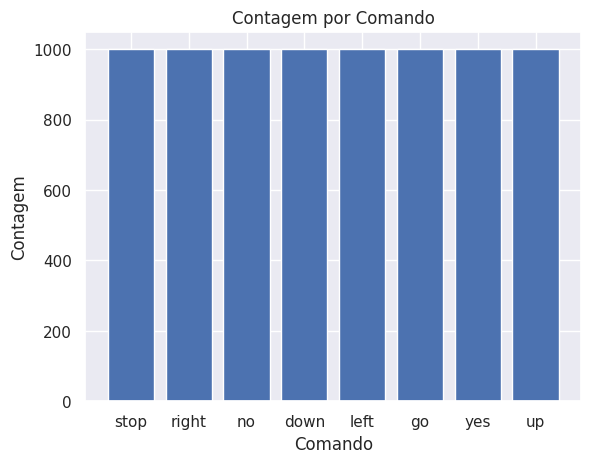

In [ ]:
# Visualiza a distribuição de comandos no dataset.
import matplotlib.pyplot as plt
command_counts = df['command'].value_counts()

plt.bar(command_counts.index, command_counts.values)
plt.xlabel('Comando')
plt.ylabel('Contagem')
plt.title('Contagem por Comando')
plt.show()

### Visualizando a distribuição da duração das gravações

In [ ]:
# Calcula e visualiza a distribuição da duração das gravações.
duration_of_recordings = []
for label in commands:
  waves = [f for f in os.listdir('/content/mini_speech_commands/' + label) if f.endswith('.wav')]
  for wav in waves:
    data, sample_rate = librosa.load('/content/mini_speech_commands/' + label + '/' + wav, sr = 16000)
    duration_of_recordings.append(float(len(data) / sample_rate))

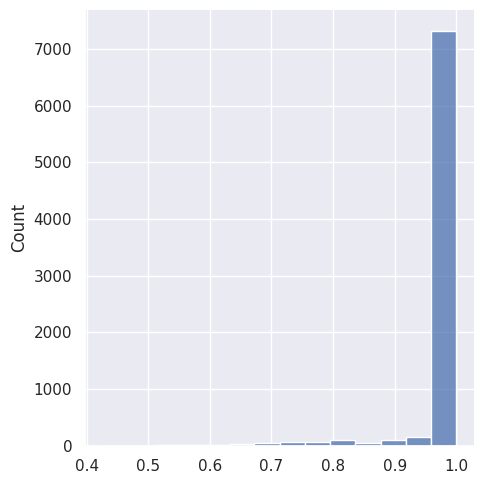

In [ ]:
# Duração das gravações
sns.displot(duration_of_recordings);

## Visalizando os dados de áudio




### Waveforms

Canais:  1
Número total de amostras: 16000
Arquivo: /content/mini_speech_commands/down/8ec6dab6_nohash_2.wav
Taxa de amostragem: 16000
Duração:  1.0


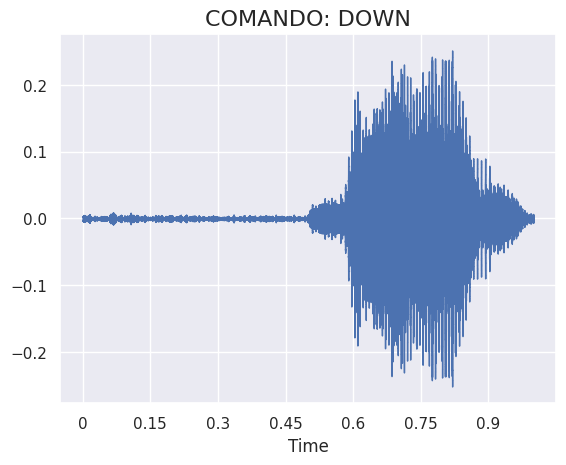

In [ ]:
# Determina o número total de arquivos no DataFrame 'df'.
n_files = df.shape[0]
rnd = np.random.randint(0, n_files)
fname = df.path[rnd]
data, sample_rate = librosa.load(fname, sr=16000)

print('Canais: ',  len(data.shape))
print('Número total de amostras:', data.shape[0])
print('Arquivo:', fname)
print('Taxa de amostragem:', sample_rate)
print('Duração: ', len(data) / sample_rate)

# Extrai informações adicionais do DataFrame relacionadas ao arquivo de áudio e exibe a forma de onda (waveform) do áudio.
info = df.iloc[rnd].values
title_txt = f'Comando: {info[0]}'
plt.title(title_txt.upper(), size=16)
librosa.display.waveshow(data, sr=sample_rate)
Audio(data = data, rate = sample_rate)

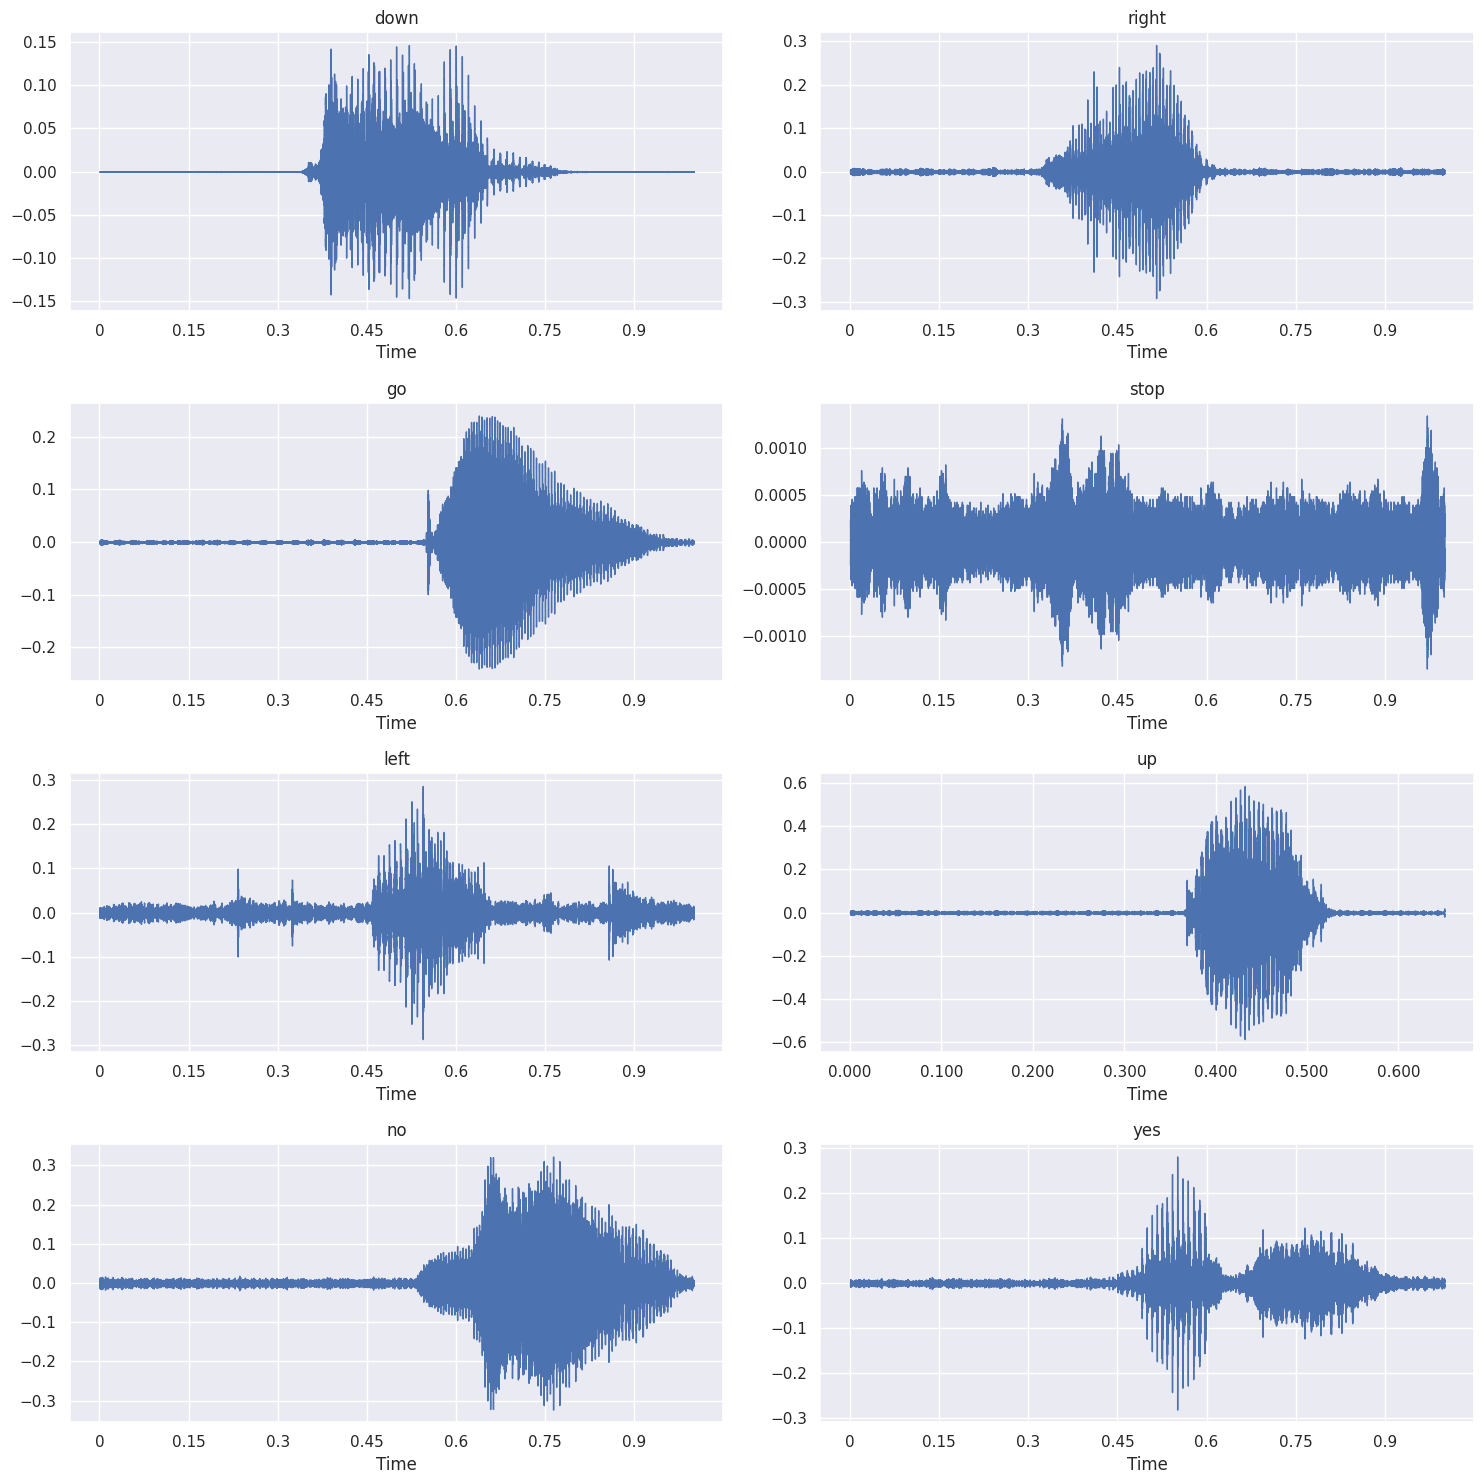

In [ ]:
# Seleciona um exemplo aleatório de cada comando (categoria) do DataFrame 'df'.
random_samples = df.groupby('command').sample(1)
audio_samples, labels = random_samples['path'].tolist(), random_samples['command'].tolist()

# Configura o layout para exibir as formas de onda (waveforms) dos arquivos de áudio selecionados.
rows=4
cols=2
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
index = 0
# Itera por cada célula do layout, carrega o arquivo de áudio, exibe sua forma de onda e define o título da célula como o rótulo do comando correspondente.
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        librosa.display.waveshow(data, sr=sample_rate, ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1

# Ajusta o layout para garantir que tudo seja exibido de forma adequada.
fig.tight_layout()

### Espectrogramas de STFT (transformada de Fourier)

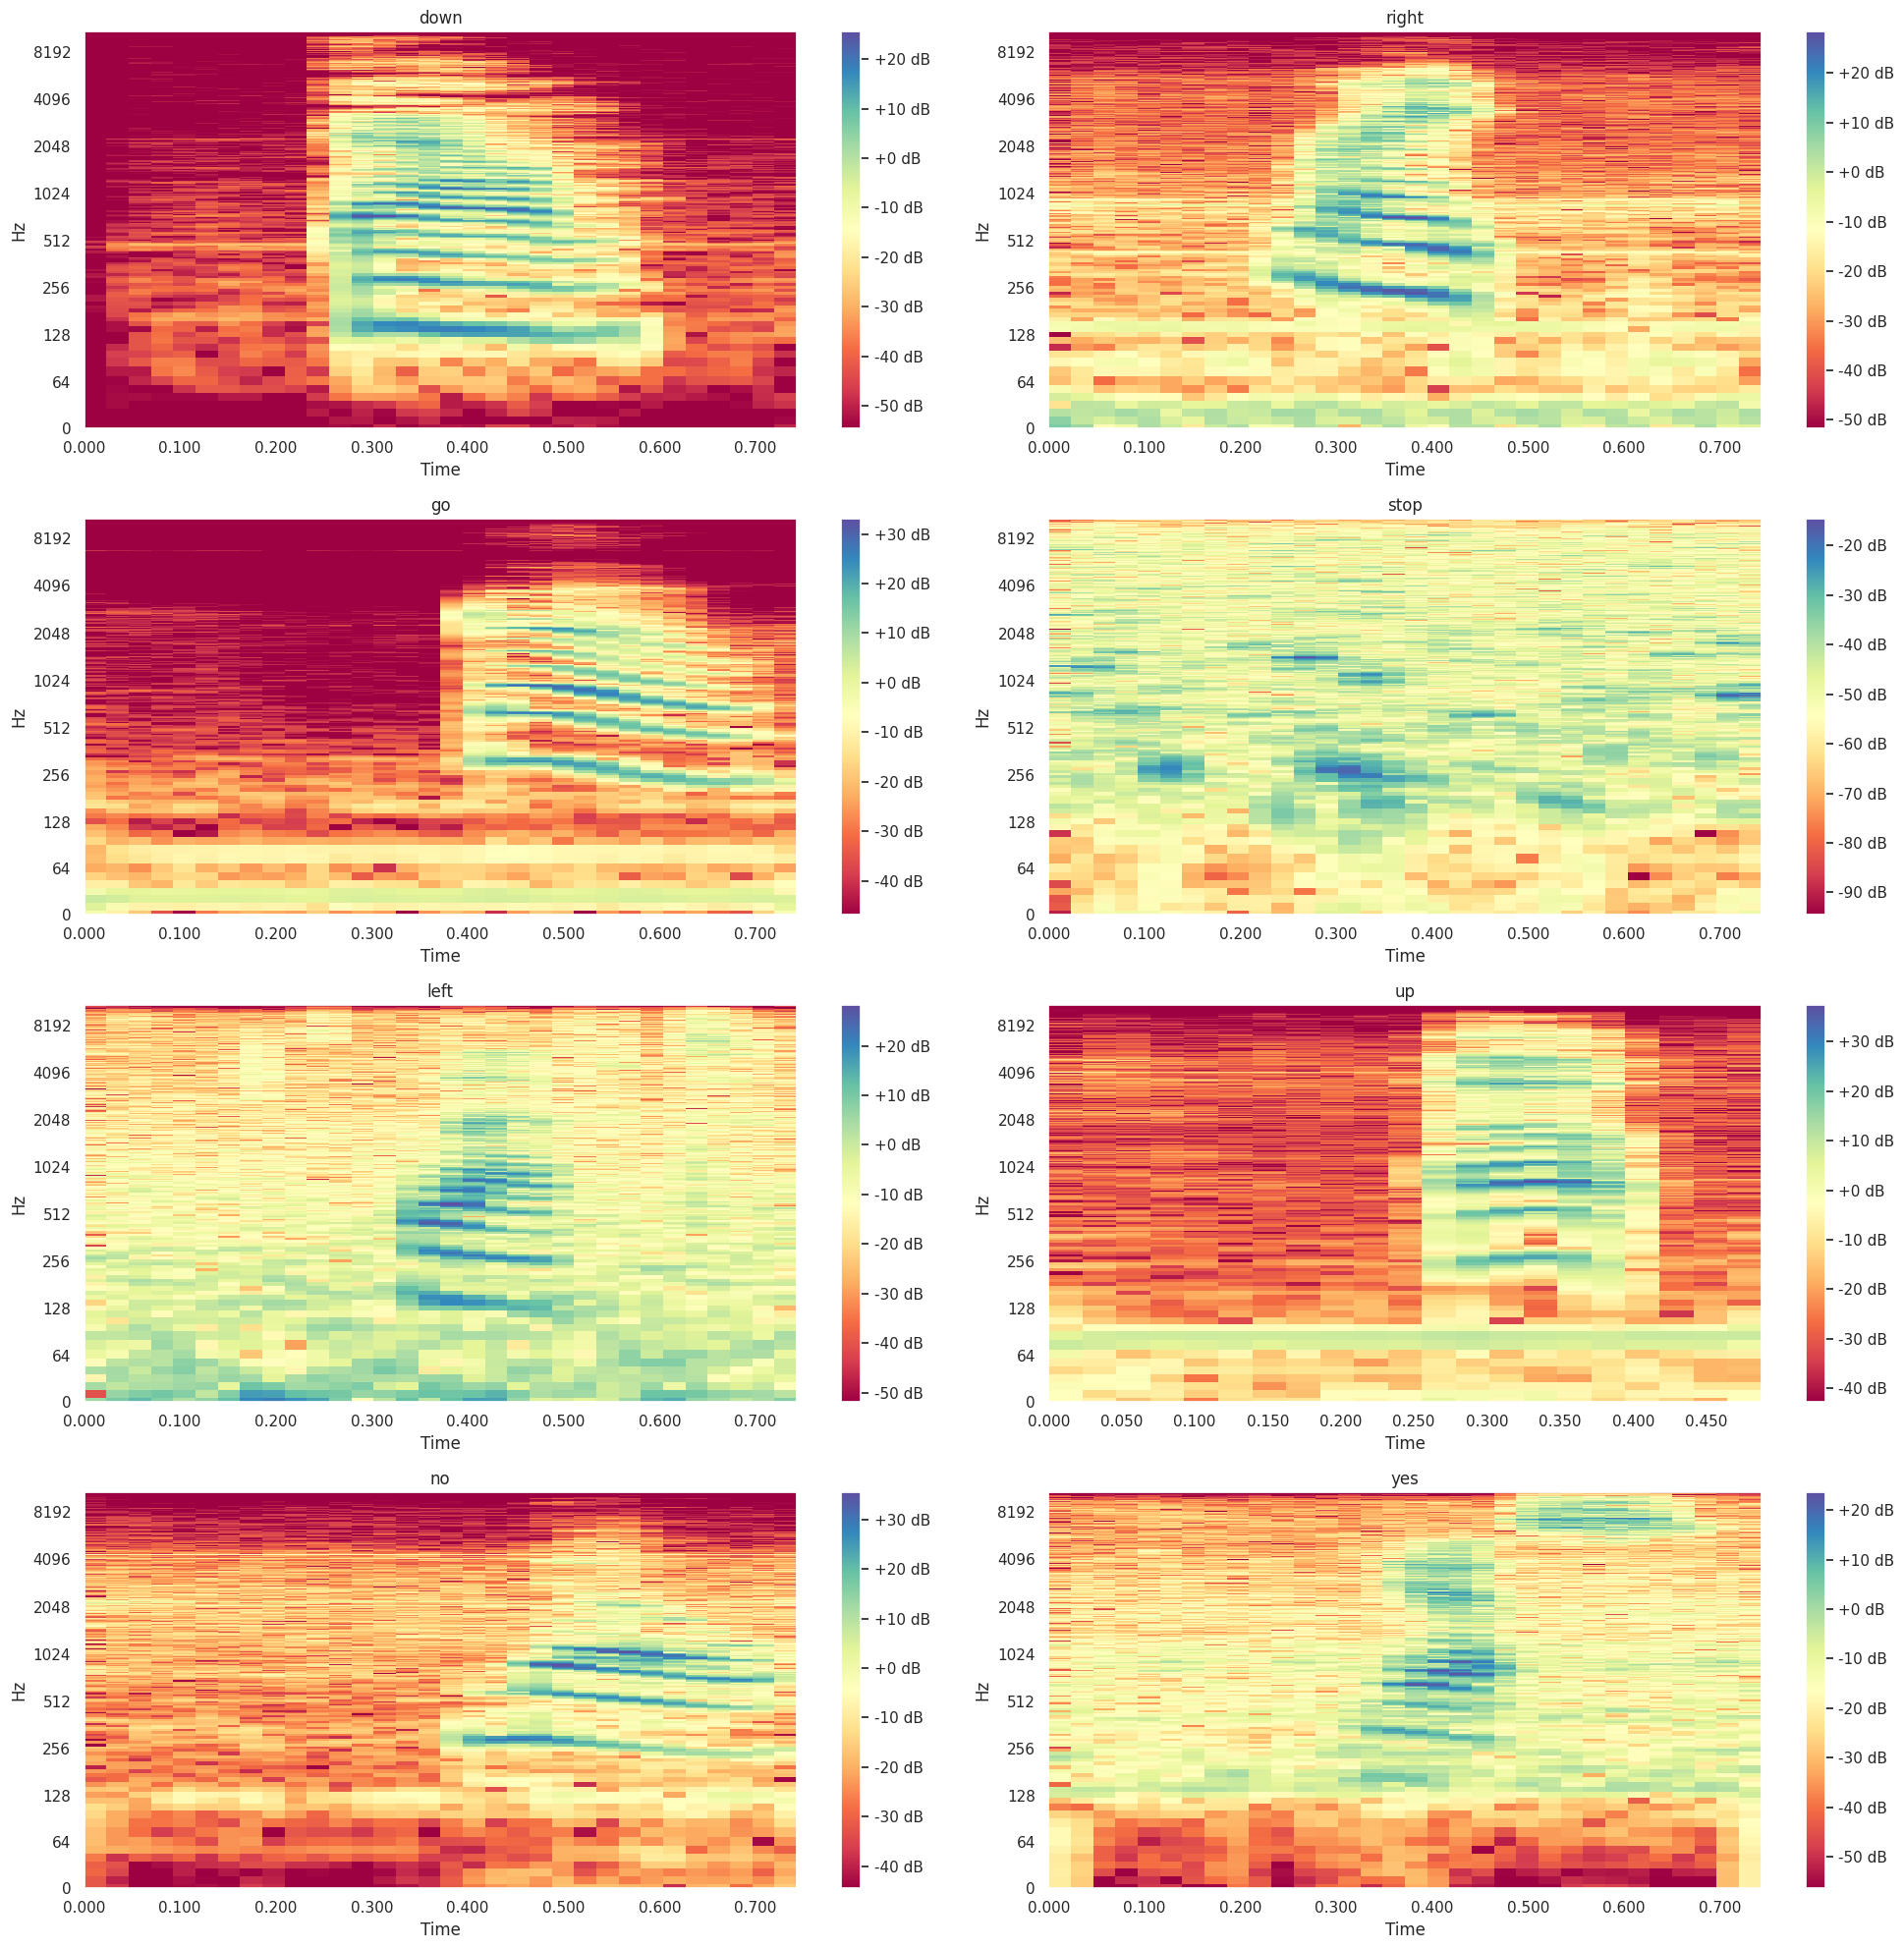

In [ ]:
# Cria uma nova figura e um array de subplots com 4 linhas e 2 colunas, com tamanho total de 20x20 polegadas.
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
# Itera por cada célula do layout para processar e exibir os espectrogramas de STFT (Short-Time Fourier Transform) dos arquivos de áudio selecionados.
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        stft = librosa.stft(y = data)
        stft_db = librosa.amplitude_to_db(np.abs(stft))
        img = librosa.display.specshow(stft_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1
fig.tight_layout()

### Espectrogramas de MFCCs

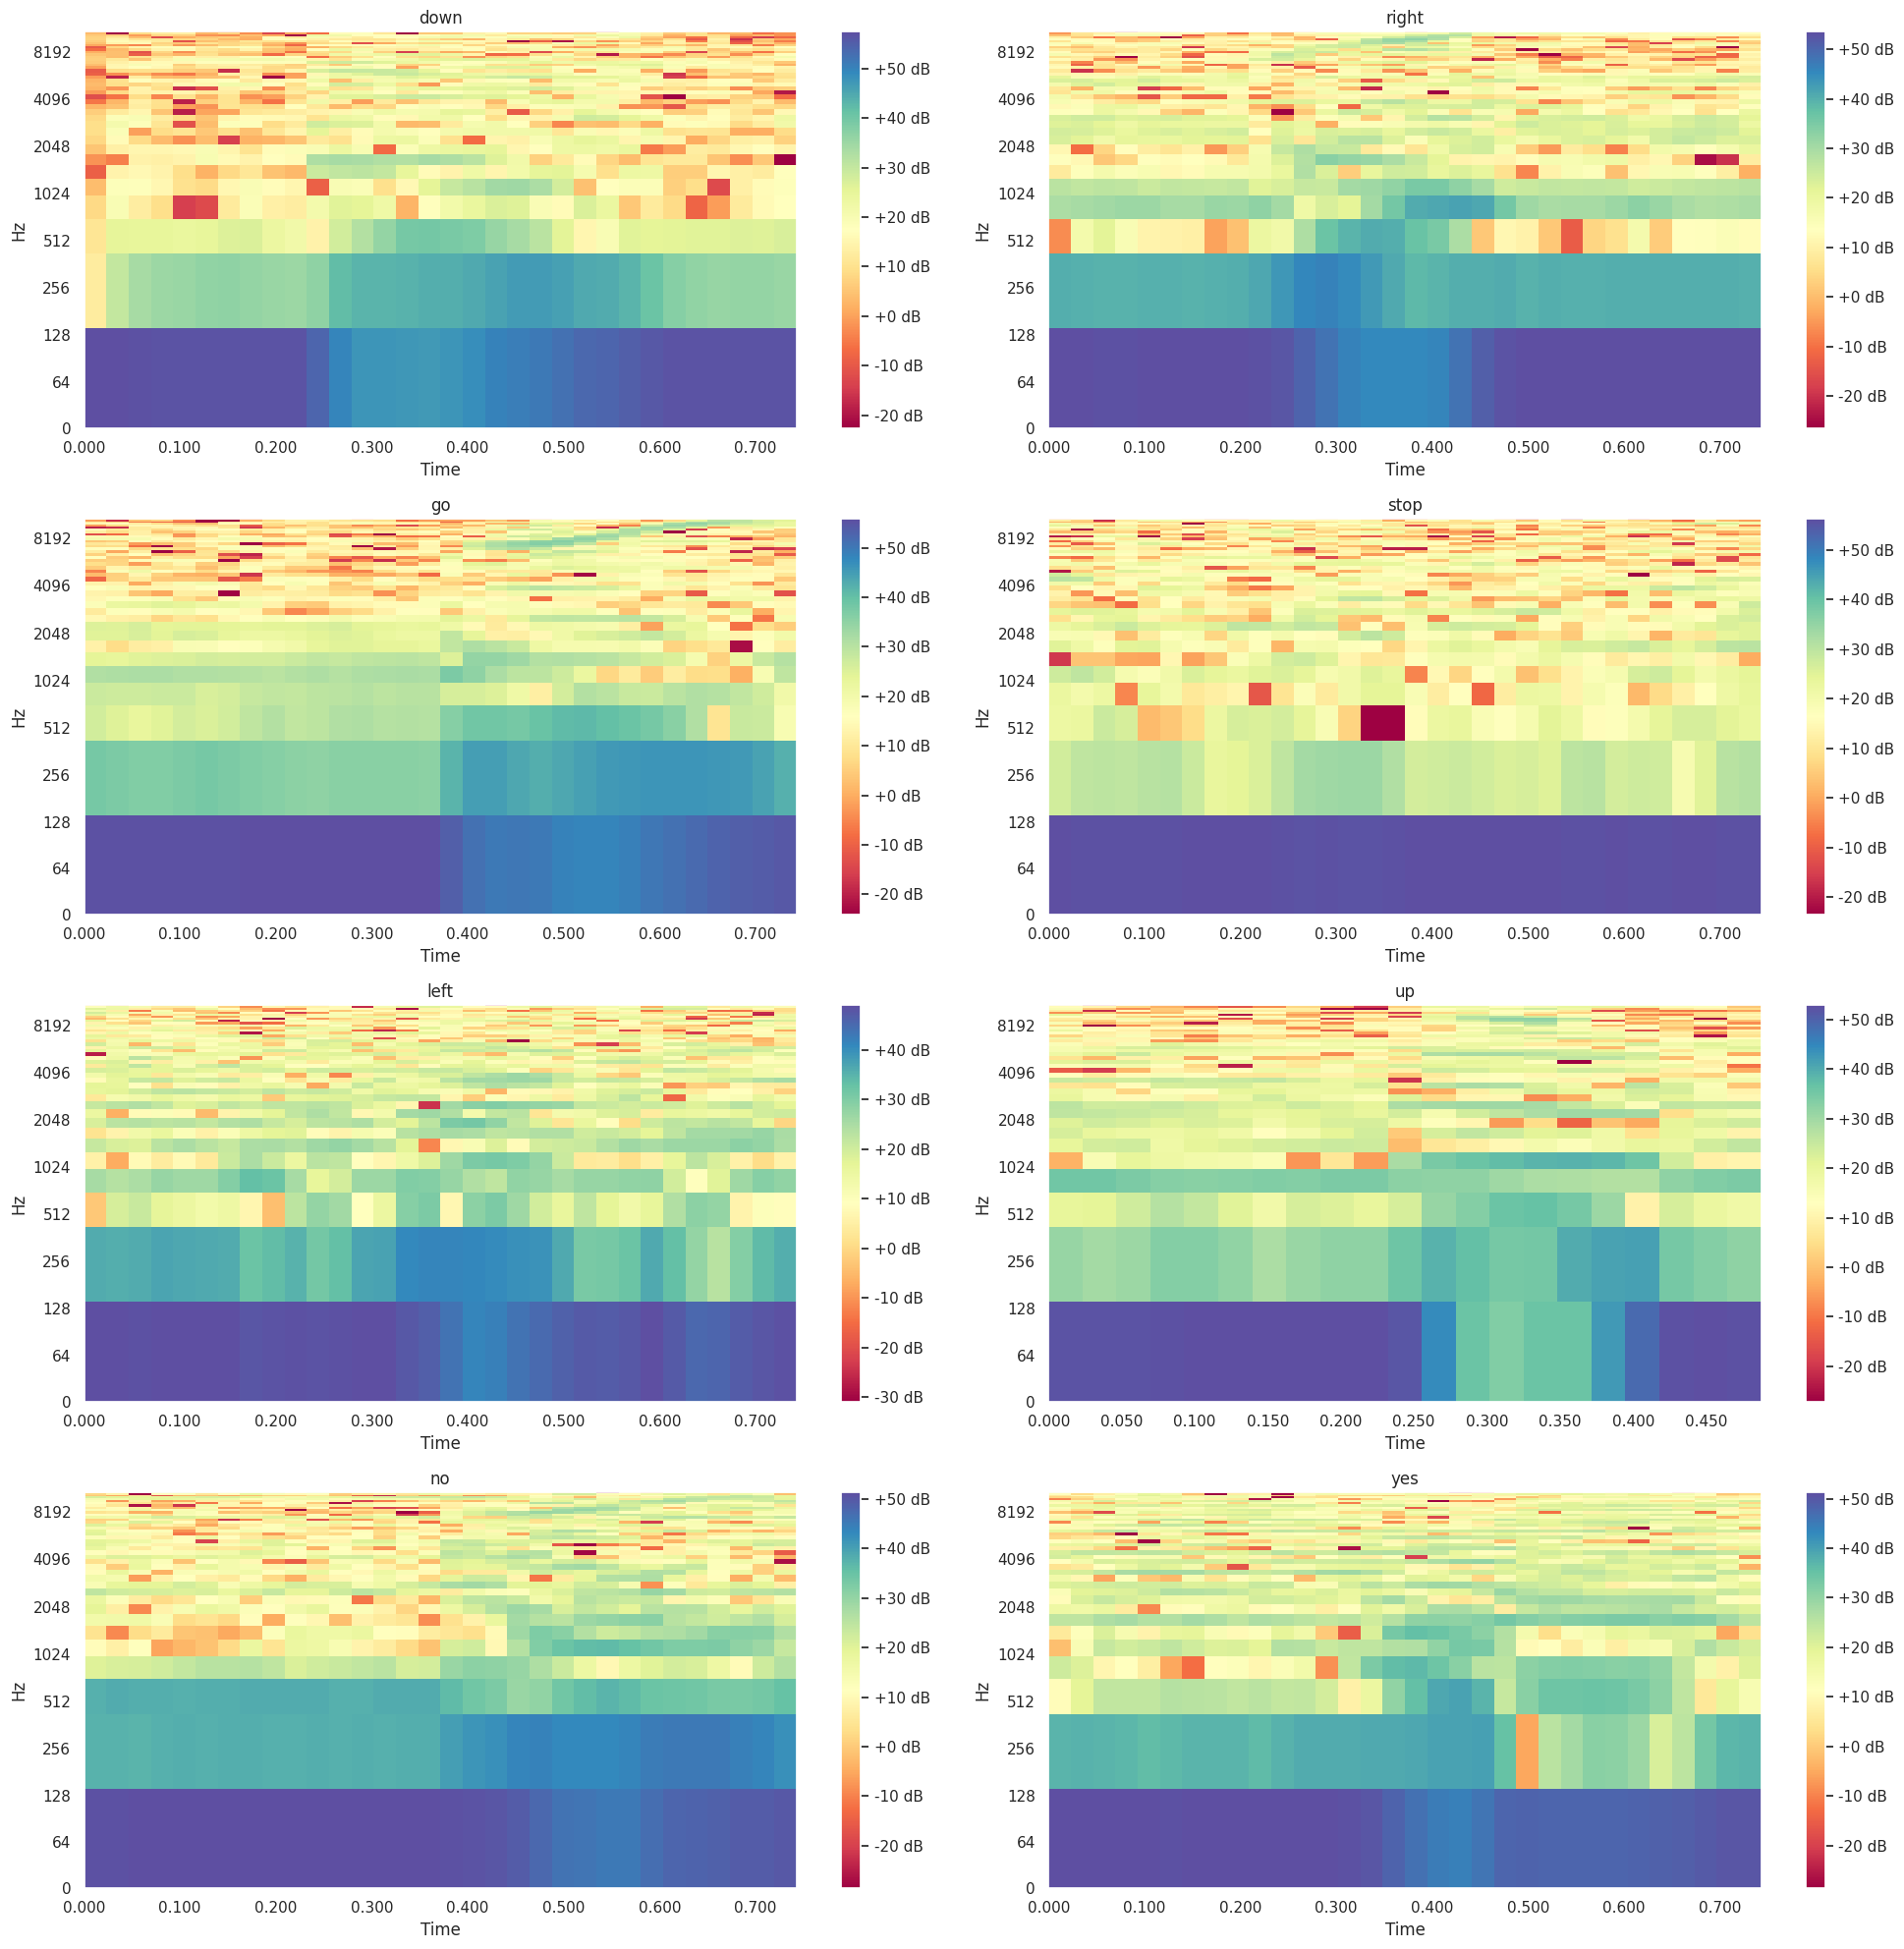

In [ ]:
# Cria uma nova figura e um array de subplots com 4 linhas e 2 colunas, com tamanho total de 20x20 polegadas.
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
# Itera por cada célula do layout para processar e exibir os espectrogramas de MFCC (Mel-Frequency Cepstral Coefficients) dos arquivos de áudio selecionados.
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=40)
        mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
        img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1

fig.tight_layout()

## Pré-processamento

### Extraindo recursos/características MFCC's de cada arquivo de áudio do dataset

In [ ]:
# Inicializa uma lista vazia para armazenar os coeficientes MFCC (Mel-Frequency Cepstral Coefficients) de cada arquivo de áudio carregado.
speech_data_mfcc = []
# Itera sobre a lista 'loaded_speech_data', que contém os dados de áudio e as taxas de amostragem correspondentes.
for loaded_audio in tqdm(loaded_speech_data):
  speech_data_mfcc.append(librosa.feature.mfcc(loaded_audio[0], loaded_audio[1]))

100%|██████████| 8000/8000 [01:12<00:00, 109.75it/s]


### Definindo a proporção da base de dados em treinamento, validação e teste

* 70% (0.7) para treinar;
* Para a validação usamos 15% (0.15);
* E para teste o restante da base de dados 15% (0.15).


In [ ]:
speech_data_as_tensor = []
# Itera sobre o índice de cada conjunto de coeficientes MFCC em 'speech_data_mfcc'.
for index in range(len(speech_data_mfcc)):
  mfcc_array = np.copy(speech_data_mfcc[index])
  mfcc_array.resize((20,32), refcheck = False)
  speech_data_as_tensor.append(tf.expand_dims(tf.convert_to_tensor(mfcc_array), -1))

In [ ]:
# Divide os dados de áudio (tensores) em três conjuntos: treinamento, validação e teste.
# A divisão é feita com base em índices específicos para garantir proporções apropriadas para cada conjunto.
# O conjunto de treinamento consiste nos primeiros 5600 elementos da lista 'speech_data_as_tensor'.
# Isso significa que os dados de 0 até 5599 (inclusive) são utilizados para treinamento.
training_slice = speech_data_as_tensor[:5600]
validation_slice = speech_data_as_tensor[5600:5600 + 1200]
testing_slice = speech_data_as_tensor[5600 + 1200:]

In [ ]:
# Cria conjuntos de dados de treinamento, validação e teste usando o TensorFlow.
# 'tf.data.Dataset.from_tensor_slices' é uma função que cria um objeto Dataset do TensorFlow.
# Cada objeto Dataset é composto por pares de elementos, onde cada par contém um tensor de áudio e um rótulo correspondente.
# O conjunto de treinamento ('training_dataset') é criado a partir de 'training_slice' e os primeiros 5600 rótulos de 'speech_label_int'.
# Isso significa que cada elemento do 'training_dataset' contém um tensor de áudio do conjunto de treinamento e seu rótulo correspondente.
training_dataset = tf.data.Dataset.from_tensor_slices((training_slice, speech_label_int[:5600]))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_slice, speech_label_int[5600:5600+1200]))
testing_dataset = tf.data.Dataset.from_tensor_slices((testing_slice, speech_label_int[-1200:]))

In [ ]:
# Definindo o tamanho do lote (batch) para o conjunto de dados de treinamento e validação.
batch_size = 10 # Cada lote contém 10 pares de áudio e rótulo.
training_dataset = training_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

## Criando o modelo

In [ ]:
norm_layer = layers.Normalization()
model = models.Sequential([
                           layers.Input(shape=(20,32,1)),
                           layers.Resizing(32,32),
                           norm_layer,
                           layers.Conv2D(32, 3, activation = 'relu'),
                           layers.Conv2D(64, 3, activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Dropout(0.25),
                           layers.Flatten(),
                           layers.Dense(128, activation = 'relu'),
                           layers.Dropout(0.25),
                           layers.Dense(num_labels), # logits
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [ ]:
# Configurando o processo de compilação do modelo.
# 'model.compile()' é usado para configurar o processo de aprendizado antes do treinamento.
# Este método configura o otimizador, a função de perda e as métricas para monitorar.
model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

## Treinando o modelo

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64

checkpointer = (tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
                tf.keras.callbacks.ModelCheckpoint(filepath='/content/saved_models/voice_command_recognition.hdf5',
                                                   save_best_only=True))

start = datetime.now()
model_history = model.fit(training_dataset, validation_data=validation_dataset, batch_size=BATCH_SIZE,
                          epochs=EPOCHS, callbacks=[checkpointer],
)
duration = datetime.now() - start
print("Treinamento concluído em: ", duration)

Epoch 1/15
560/560 [==============================] - 32s 56ms/step - loss: 1.7495 - accuracy: 0.4304 - val_loss: 0.9415 - val_accuracy: 0.6533
Epoch 2/15
  1/560 [..............................] - ETA: 25s - loss: 1.2676 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


560/560 [==============================] - 31s 55ms/step - loss: 0.8523 - accuracy: 0.6941 - val_loss: 0.6399 - val_accuracy: 0.7750
Epoch 3/15
560/560 [==============================] - 38s 68ms/step - loss: 0.5802 - accuracy: 0.7921 - val_loss: 0.6802 - val_accuracy: 0.7708
Epoch 4/15
560/560 [==============================] - 38s 69ms/step - loss: 0.4509 - accuracy: 0.8388 - val_loss: 0.6877 - val_accuracy: 0.7917
Epoch 4: early stopping
Treinamento concluído em:  0:02:23.021820


## Avaliando o modelo

In [ ]:
# Preparando os dados de áudio e rótulos de teste para avaliação do modelo.
test_audio_data = []
test_label_data = []
# Itera sobre cada par de áudio e rótulo no conjunto de dados de teste.
for audio, label in testing_dataset:
  test_audio_data.append(audio.numpy())
  test_label_data.append(label.numpy())

In [ ]:
# Convertendo as listas de dados de áudio e rótulos de teste para arrays NumPy.
test_audio_data = np.array(test_audio_data)
test_label_data = np.array(test_label_data)

In [ ]:
# Estabelecendo as predições do modelo
y_pred = np.argmax(model.predict(test_audio_data), axis = 1)
y_true = test_label_data

38/38 [==============================] - 2s 54ms/step


array([2, 0, 7, ..., 3, 0, 5])

In [ ]:
print('Taxa de acerto: ', sum(y_pred == y_true) / len(y_true))

Taxa de acerto:  0.7675


## Exbindo as métricas de precisão e perda do modelo

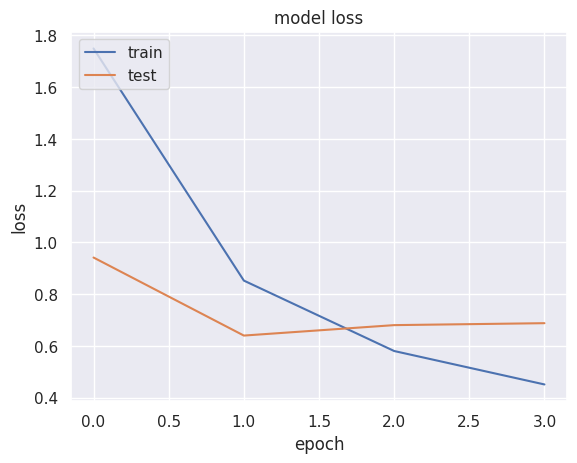

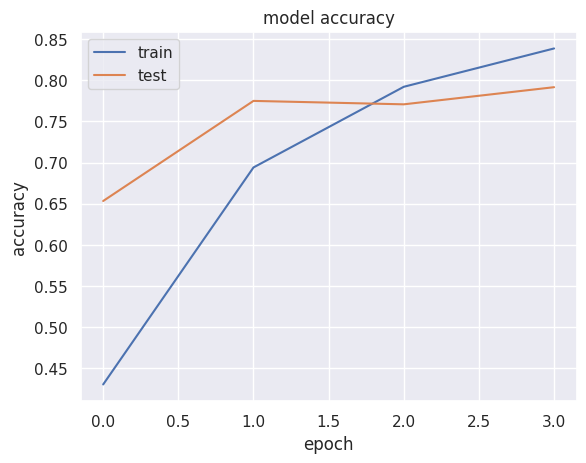

In [ ]:
metrics = model_history.history
plt.plot(model_history.epoch, metrics['loss'], metrics['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Exibindo a Matriz de confusão

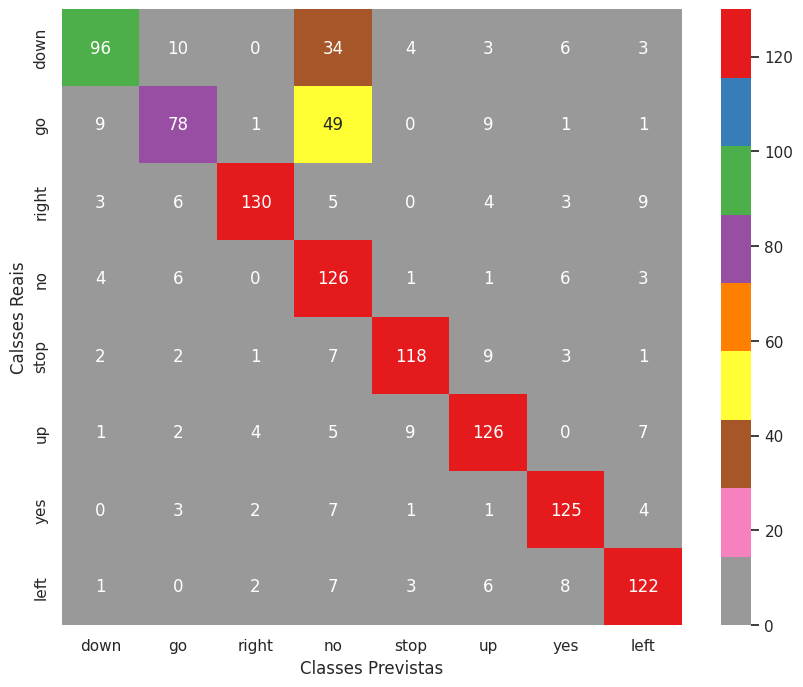

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands_dict, yticklabels=commands_dict, annot=True, fmt='g', cmap='Set1_r')
plt.xlabel('Classes Previstas')
plt.ylabel('Calsses Reais')
plt.show()

# Executar inferência em um arquivo de áudio

In [ ]:
def predict(sample_file):
  audio, sample_rate = librosa.load(sample_file, sr = 16000)
  mfcc = librosa.feature.mfcc(audio)
  mfcc_array = np.copy(mfcc)
  mfcc_array.resize((20,32), refcheck=False)
  speech_tensor = tf.expand_dims(tf.convert_to_tensor(mfcc_array), -1)
  speech_tensor = tf.expand_dims(speech_tensor, axis = 0)
  prediction = model(speech_tensor)
  index = np.argmax(prediction[0])
  result = 'Comando previsto: ' + commands[index]
  plt.bar(commands, tf.nn.softmax(prediction[0]), color = list('rgbkymc'))
  plt.title(str(result).upper())

Arquivo:  7885
Path:  /content/mini_speech_commands/left/105e72bb_nohash_1.wav


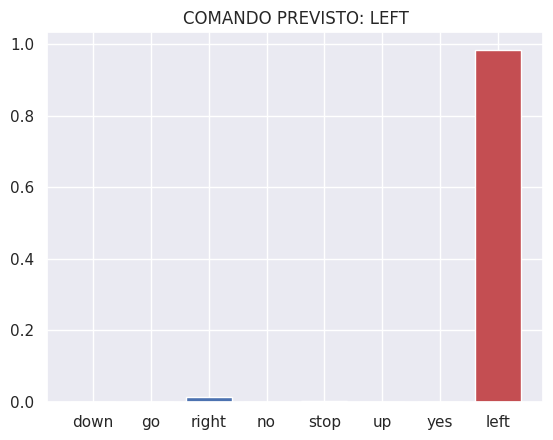

In [ ]:
filenames = tf.io.gfile.glob('/content/mini_speech_commands' + '/*/*') # Execute esta célula para visualizar diferentes comandos e seu acerto.
n_files = len(filenames)
rnd = np.random.randint(0, n_files)
fname = filenames[rnd]
print('Arquivo: ', rnd)
print('Path: ', fname)
predict(fname)
audio, sample_rate = librosa.load(fname, sr = 16000)
Audio(data = audio, rate = sample_rate)